# Network Simulation
## Daniel Mishler
### Network simulation to consider combining networking algorithms for distance

In [1]:
import numpy as np
import networkx as nx

In [2]:
testAdj = [[0, 1, 0],
           [1, 0, 1],
           [0, 1, 0]]

In [3]:
def list_from_adj(adj):
    edges_list = []
    if len(adj) != len(adj[0]):
        print("something wrong with adjacency matrix")
        return edges_list
    size_adj = len(adj)
    for i in range(size_adj):
        for j in range(i+1,size_adj):
            if adj[i][j]:
                edges_list.append((i,j))
    return edges_list

In [4]:
def nx_graph_from_adj(adj):
    if len(adj) != len(adj[0]):
        print("something wrong with adjacency matrix")
        return
    size_adj = len(adj)
    edges_list = list_from_adj(adj)
    
    G = nx.Graph()
    G.add_nodes_from(range(size_adj))
    G.add_edges_from(edges_list)
    return G

In [5]:
G = nx_graph_from_adj(testAdj)

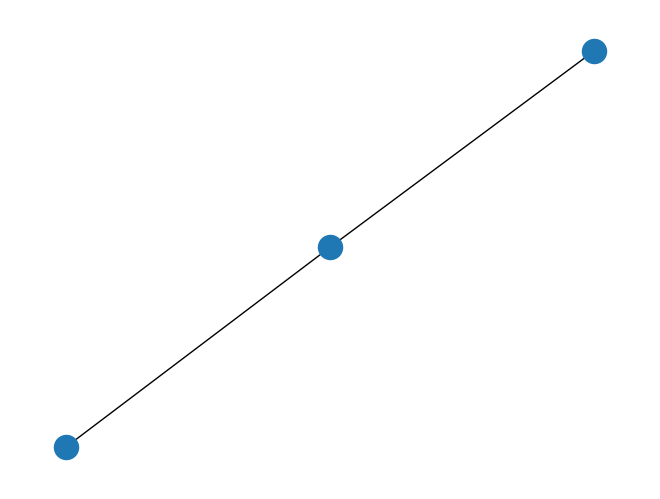

In [6]:
nx.draw(G)

In [7]:
import random
import dgl
def random_adj(nvertices, nedges):
    # Returns adjacency matrix
    max_nedges = (nvertices*(nvertices-1))//2
    if nedges > max_nedges:
        print(f"error: too many edges added. maximum is {max_nedges} for {nvertices} vertices")
        return None
    
    adj = [[0 for i in range(nvertices)] for j in range(nvertices)]
    
    for e in range(nedges):
        edge_valid = False
        while edge_valid is False:
            rand = random.randint(0, nvertices*nvertices-1)
            which_row = rand // nvertices
            which_col = rand % nvertices
            if (which_row != which_col) and adj[which_row][which_col] == 0:
                edge_valid = True
        adj[which_row][which_col] = 1
        adj[which_col][which_row] = 1
    
    return adj
def matrix_to_dgl_lists(adj):
    from_list = []
    to_list = []
    i =  0
    nvertices = len(adj)
    while i < nvertices:
        j = i+1
        while j < nvertices:
            if adj[i][j] == 1:
                from_list.append(i)
                to_list.append(j)
                
                # remove this and there's probably a way to go directed here.
                to_list.append(i)
                from_list.append(j)
            j += 1
        i += 1
    
    return from_list, to_list

In [8]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

In [9]:
def adj_to_dgl(adj):
    from_list, to_list = matrix_to_dgl_lists(adj)
    g = dgl.graph((from_list, to_list))
    return g
def draw_g(g):
    nx.draw_networkx(g.to_networkx())

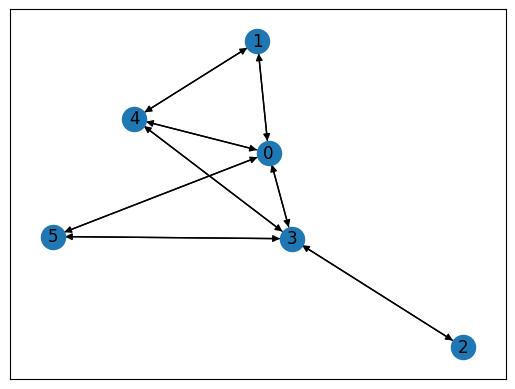

In [10]:
nvertices = 6
nedges = 8
MAX_DISTANCE = 20

adj = random_adj(nvertices,nedges)

g = adj_to_dgl(adj)
draw_g(g)

In [11]:
def empty_routing_dict():
    return {"distance": MAX_DISTANCE, "first_hop": -1}
def empty_routing_table():
    return [empty_routing_dict() for i in range(nvertices)]

In [12]:
class Router:
    def __init__(self, my_number, neighbors):
        self.my_number = my_number
        self.neighbors = neighbors
        self.table_queue = []
        self.routing_table = empty_routing_table()
        self.init_routing_table()
        self.all_tables = {} # for link state
        self.reconstructed_adj = None
        self.router_list = None # will be populated later
        self.table_sends = 0
    def init_routing_table(self):
        self.routing_table = empty_routing_table()
        self.routing_table[self.my_number]["distance"] = 0
        for neighbor in self.neighbors:
            self.routing_table[neighbor]["distance"] = 1
            self.routing_table[neighbor]["first_hop"] = neighbor
    def print_adj_table(self):
        print("target | distance | first hop")
        print("-------|----------|----------")
        for i in range(nvertices):
            print(f"{i:>6} | {self.routing_table[i]["distance"]:>8} | {self.routing_table[i]["first_hop"]:>7}")
    
    ### Distance Vector functions
    # deprecated and - FOR GLOBAL
    def update_routing_table_global_dv(self):
        # Take the first element of the queue of tables and update self table
        in_table = self.table_queue[0]["table"]
        in_sender = self.table_queue[0]["sender"]
        
        table_changed = False
        for i in range(nvertices):
            if in_table[i]["distance"]+1 < self.routing_table[i]["distance"]:
                # if this new table offers a faster route
                self.routing_table[i]["distance"] = in_table[i]["distance"]+1
                self.routing_table[i]["first_hop"] = in_sender
                # then the new fastest route is sent that direction
                table_changed = True
            
        self.table_queue = self.table_queue[1:] # pop from the queue
        return table_changed
    def clear_table_queue_global_dv(self):
        table_changed = False
        while len(self.table_queue) > 0:
            table_changed = self.update_routing_table_global_dv()
        return table_changed    ### Distance Vector functions
    
    # For local, proper version
    def update_routing_table(self, verbose=False):
        # Take the first element of the queue of tables and update self table
        in_table = self.table_queue[0]["table"]
        in_sender = self.table_queue[0]["sender"]
        response_req = self.table_queue[0]["response"]
        
        table_changed = False
        # Check to make sure my paths still exist
        for i in range(nvertices):
            if self.routing_table[i]["first_hop"] == in_sender:
                # Then the my path length needs to be exactly theirs, plus one.
                if self.routing_table[i]["distance"] < in_table[i]["distance"]+1:
                    self.routing_table[i]["distance"] = in_table[i]["distance"]+1
                    table_changed=True
        
        # Grab faster paths from the table
        for i in range(nvertices):
            if in_table[i]["distance"]+1 < self.routing_table[i]["distance"]:
                # if this new table offers a faster route
                self.routing_table[i]["distance"] = in_table[i]["distance"]+1
                self.routing_table[i]["first_hop"] = in_sender
                # then the new fastest route is sent that direction
                table_changed = True
        
        if verbose:
            print(f"router {self.my_number} processed table from {in_sender}")
        if table_changed:
            if verbose:
                print("yes, changed table. Sending out to all neighbors.")
                self.print_adj_table()
                print()
                print()
            self.send_request_to_neighbors()
        elif response_req: # We didn't change our table, but the sender wanted a response
            if verbose:
                print("no, did not change table, but sending back per request")
            self.send_request_back(in_sender)
        else:
            if verbose:
                print(f"No need for more action.")
            pass
        
        self.table_queue = self.table_queue[1:] # pop from the queue
        return table_changed
    def send_request_to_neighbors(self):
        request_dict = {}
        request_dict["table"] = self.routing_table
        request_dict["response"] = True
        request_dict["sender"] = self.my_number
        for neighbor in self.neighbors:
            self.router_list[neighbor].table_queue.append(request_dict)
            self.table_sends += 1
        return
    def send_request_back(self, target):
        request_dict = {}
        request_dict["table"] = self.routing_table
        request_dict["response"] = False
        request_dict["sender"] = self.my_number
        self.router_list[target].table_queue.append(request_dict)
        self.table_sends += 1
        return
    def clear_table_queue(self):
        table_changed = False
        while len(self.table_queue) > 0:
            table_changed = self.update_routing_table()
        return table_changed
    
    ### Link State functions
    def reconstruct_adj(self):
        self.reconstructed_adj = [[0 for i in range(nvertices)] for j in range(nvertices)]
        for key in self.all_tables:
            table = self.all_tables[key]
            neighbors = []
            for i in range(len(table)):
                if table[i]["distance"] == 1:
                    neighbors.append(i)
            for i in neighbors:
                self.reconstructed_adj[key][i] = 1
    def dijkstra_to_table(self):
        seeking_distance = 1 # start from 1 because 0 is already done.
        while True:
            updated_table = False
            for i in range(nvertices):
                if self.routing_table[i]["distance"] > seeking_distance:
                    for j in range(nvertices):
                        if self.reconstructed_adj[i][j]:
                            if self.routing_table[j]["distance"] == seeking_distance:
                                self.routing_table[i]["distance"] = seeking_distance + 1
                                self.routing_table[i]["first_hop"] = self.routing_table[j]["first_hop"]
                                updated_table = True
                            elif self.routing_table[j]["distance"] < seeking_distance:
                                print("some kind of error occured. Abort.")
                                return
            seeking_distance += 1
            if updated_table is False:
                break # alternatively, we could stop when all entries are filled

In [13]:
def init_routers():
    routers = []
    for i in range(nvertices):
        neighbors_of_i = []
        for j in range(nvertices):
            if adj[i][j]:
                neighbors_of_i.append(j)
        routers.append(Router(i,neighbors_of_i))
    for router in routers:
        router.router_list = routers
    return routers

### Distance Vector

In [14]:
def distance_via_dv_global():
    update_num = 0
    send_count_dv = 0
    while True:
        # print(f"update {update_num}")
        update_num += 1
        for router in routers:
            for neighbor in router.neighbors:
                send_dict = {"sender": router.my_number, "table": router.routing_table}
                routers[neighbor].table_queue.append(send_dict)
                send_count_dv += 1
        updated_at_least_one_path = False
        for router in routers:
            updated_at_least_one_path |= router.clear_table_queue_global_dv()
        if updated_at_least_one_path is False:
            break

    return (update_num, send_count_dv)

In [15]:
def queues_full():
    which_queues = []
    for i in range(len(routers)):
        if len(routers[i].table_queue) > 0:
            which_queues.append(i)
    return which_queues

In [16]:
def reset_table_sends():
    for router in routers:
        router.table_sends = 0

In [17]:
def distance_via_dv(initiating_router):
    reset_table_sends()
    routers[initiating_router].send_request_to_neighbors()
    
    while(len(queues_full()) > 0):
        which_queues = queues_full()
        run_this_one = which_queues[random.randrange(len(which_queues))]
        routers[run_this_one].update_routing_table(verbose=False) # could also do all updates
    
    total_sends = 0
    for router in routers:
        total_sends += router.table_sends
    return total_sends

### Link State

In [18]:
def dfw_wrapper(adj, root):
    send_count = 0
    visited = [0 for i in range(nvertices)]
    table_to_send = routers[root].routing_table
    def dfw(adj, start): # depth-first-forwarding
        routers[start].all_tables[root] = table_to_send
        visited[start] = 1
        for i in range(nvertices):
            if adj[start][i] == 1 and visited[i] == 0:
                dfw(adj, i)

    dfw(adj, root)
    # to send the table dfw to nvertices, it takes nvertices-1 sends
    send_count = nvertices-1
    return send_count

In [19]:
def distance_via_ls():
    send_count_ls = 0
    for i in range(nvertices):
        send_count_ls += dfw_wrapper(adj, i)
    for router in routers:
        router.reconstruct_adj()
        router.dijkstra_to_table()
    return send_count_ls

### Topology Change (Eliminating an edge or adding one)

In [20]:
def change_adj(i, j, add_or_remove=True):
    # add_or_remove: True for add, False for remove
    
    # check:
    if add_or_remove and adj[i][j]==1:
        # then do nothing
        return
    if not add_or_remove and adj[i][j]==0:
        # also do nothing
        return
    
    if add_or_remove is True:
        adj[i][j] = 1
        adj[j][i] = 1
        routers[j].neighbors.append(i)
        routers[i].neighbors.append(j)

    if add_or_remove is False:
        adj[i][j] = 0
        adj[j][i] = 0
        routers[j].neighbors.remove(i)
        routers[i].neighbors.remove(j)
    
    routers[j].init_routing_table()
    routers[i].init_routing_table()

In [21]:
# change_adj(0,2,True)

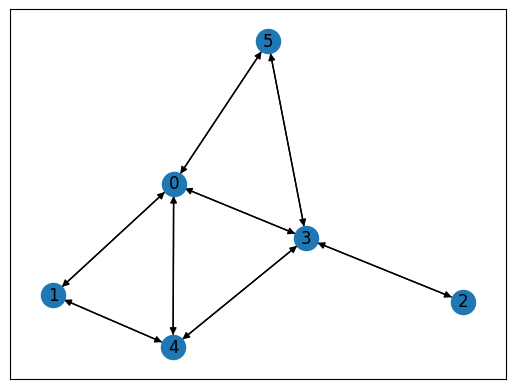

In [22]:
g = adj_to_dgl(adj)
draw_g(g)

### Comparison

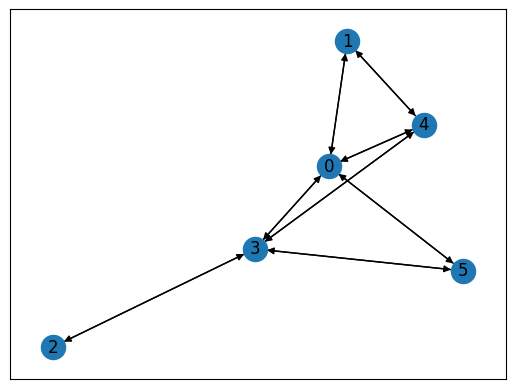

In [23]:
# draw again
draw_g(g)

In [24]:
routers = init_routers()
(update_num_dv_global,send_count_dv_global) = distance_via_dv_global()
print(f"total updates: {update_num_dv_global}\ntotal sent tables: {send_count_dv_global}")

total updates: 3
total sent tables: 48


In [25]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        1 |       1
     2 |        2 |       3
     3 |        1 |       3
     4 |        1 |       4
     5 |        1 |       5


In [26]:
routers = init_routers()
send_count_ls = distance_via_ls()
print(f"total sent tables: {send_count_ls}")

total sent tables: 30


In [27]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        1 |       1
     2 |        2 |       3
     3 |        1 |       3
     4 |        1 |       4
     5 |        1 |       5


In [28]:
# routers = init_routers()
send_count_dv = distance_via_dv(0)
print(f"total sent tables: {send_count_dv}")

total sent tables: 8


In [29]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        1 |       1
     2 |        2 |       3
     3 |        1 |       3
     4 |        1 |       4
     5 |        1 |       5


In [30]:
print(f"global dv       send count: {send_count_dv_global} over {update_num_dv_global} updates")
print(f"link state      send count: {send_count_ls}")
print(f"distance vector send count: {send_count_dv}")
print()
print()
print(f"memory footprint: {nvertices} tables per router")

global dv       send count: 48 over 3 updates
link state      send count: 30
distance vector send count: 8


memory footprint: 6 tables per router
